<a href="https://colab.research.google.com/github/yohanesnuwara/DASLab/blob/main/notebooks/DASCompare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this notebook is to make a comparison of various DAS acquisitions in Ichihara site, where 3 DAS acquisitions (straight cable STC, helically wound HWC, and behind casing BC) are installed both in the borehole and buried on the surface.

## Set up

In [ ]:
# Install libraries in Colab
!pip install -q utm
!pip install -q nptdms==0.25.0 # Older version
!pip install -q obspy

# Import routine libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from scipy import signal, stats
import pandas as pd

# Plot formatting
plt.rcParams["font.size"] = 20
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

from nptdms import TdmsFile
import utm

     |████████████████████████████████| 153kB 9.2MB/s 
     |████████████████████████████████| 24.7MB 162kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


In [ ]:
# Access DASLab repository
!git clone 'https://github.com/yohanesnuwara/DASLab'

import sys
sys.path.append('/content/DASLab')

from input_output import loadPkl
from TDMS_Functions import *
from signalprocessing import *
from autopick import *
from dasplot import *

Cloning into 'DASLab'...
remote: Enumerating objects: 277, done.
remote: Counting objects: 100% (277/277), done.
remote: Compressing objects: 100% (272/272), done.
remote: Total 277 (delta 157), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (277/277), 11.09 MiB | 8.97 MiB/s, done.
Resolving deltas: 100% (157/157), done.


In [ ]:
# Connect to Goo Drive to access data
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Load data via Pickles

In [ ]:
# Takes 1 minute to load all 8 files from pickle. Takes nearly half the Colab RAM.
dir = "/content/drive/MyDrive/RITE_Yohanes/Pickles/"
n_events = 8 # Number of events to load

stc, hwc, bc = [], [], []
for i in range(n_events):
  filename = dir+'file'+'{}'.format(i+1)+'.pkl'
  f = loadPkl(filename)
  stc.append(f[:,:246])
  hwc.append(f[:,246:246+277])
  bc.append(f[:,246+277:246+277+737])

In [ ]:
# Convert to Numpy array
bc = np.array(bc)
hwc = np.array(hwc)
stc = np.array(stc)

## Compare waveform

Plot the waveforms in VSP style (vertical time vs. depth) and compare between STC, HWC, and BC. Then take the difference.

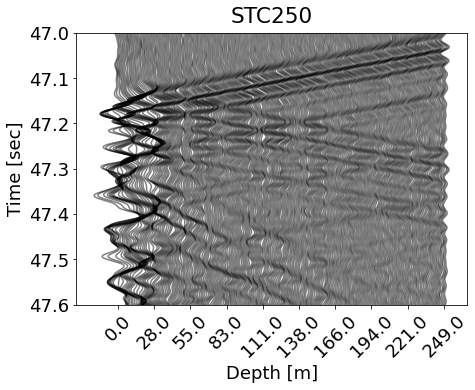

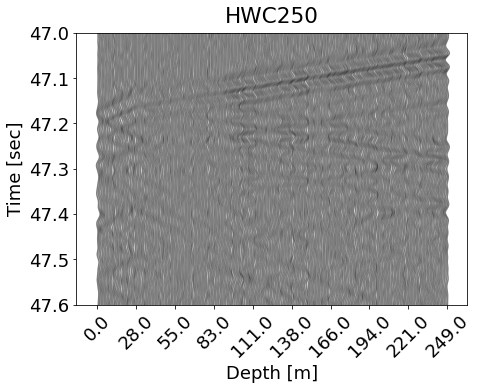

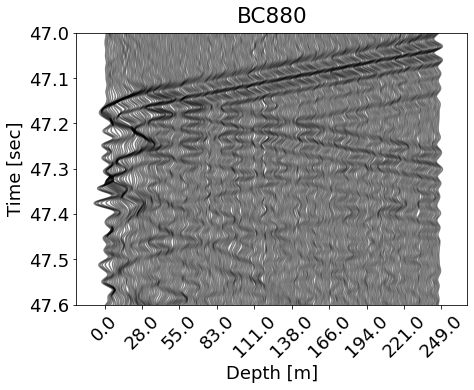

In [ ]:
# P arrival
ylim = (47.,47.6) # Depth 
xlim = (0,250) # Time

plotVSP(event.stc250, magnify=15, ylim=ylim, xlim=xlim, alpha=0.5,
        title="STC250")
plt.show()

plotVSP(event.hwc250, magnify=15, ylim=ylim, xlim=xlim, alpha=0.5,
        title="HWC250")
plt.show()

plotVSP(event.bc880, magnify=15, ylim=ylim, xlim=xlim, alpha=0.5,
        title="BC880")
plt.show()

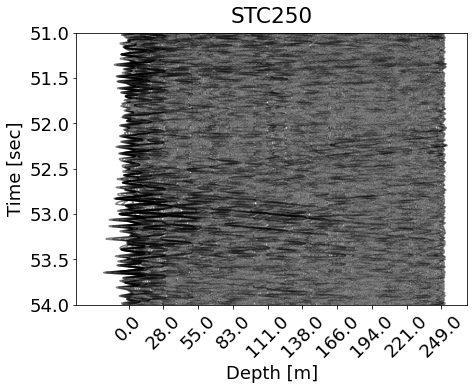

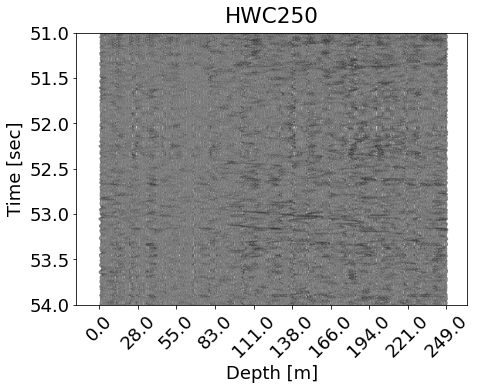

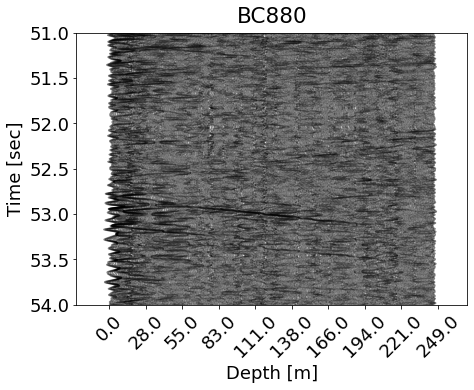

In [ ]:
# S arrival
ylim = (51,54)
xlim = (0,250)

plotVSP(event.stc250, magnify=10, ylim=ylim, xlim=xlim, alpha=0.5,
        title="STC250")
plt.show()

plotVSP(event.hwc250, magnify=10, ylim=ylim, xlim=xlim, alpha=0.5,
        title="HWC250")
plt.show()

plotVSP(event.bc880, magnify=10, ylim=ylim, xlim=xlim, alpha=0.5,
        title="BC880")
plt.show()

In [ ]:
# Take difference
dif1 = difference(event.stc250, event.bc880)
dif2 = difference(event.stc250, event.hwc250)
dif3 = difference(event.hwc250, event.bc880)

tt1, zz1 = event.stc250.tt, event.stc250.zz
tt2, zz2 = tt1, zz1
tt3, zz3 = event.hwc250.tt, event.hwc250.tt

# Create TDMS object from the calculated difference
x1 = TDMSEvent(dif1, tt1, zz1)
x2 = TDMSEvent(dif2, tt2, zz2)
x3 = TDMSEvent(dif3, tt3, zz3)


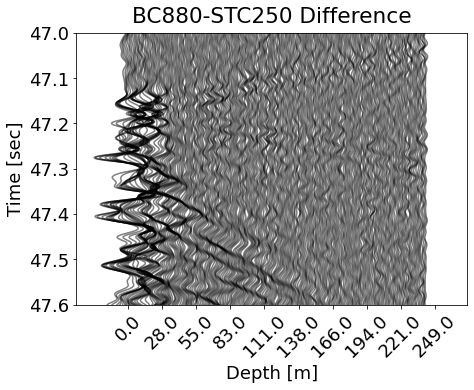

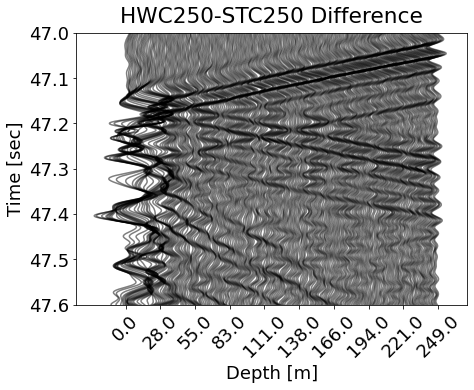

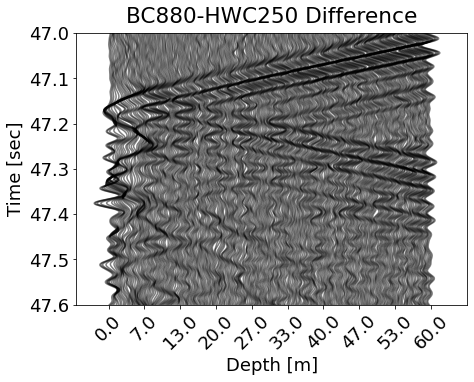

In [ ]:
# Plot difference
ylim = (47,47.6)
xlim = (0,250)

plotVSP(x1, magnify=10, ylim=ylim, xlim=xlim, alpha=0.5, title='BC880-STC250 Difference')
plt.show()

plotVSP(x2, magnify=10, ylim=ylim, xlim=xlim, alpha=0.5, title='HWC250-STC250 Difference')
plt.show()

plotVSP(x3, magnify=10, ylim=ylim, xlim=xlim, alpha=0.5, title='BC880-HWC250 Difference')
plt.show()

## Comparison of STC vs. HWC vs. BC

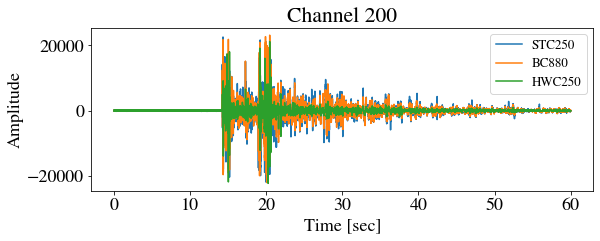

In [ ]:
no_event = 1 # Specify which event
no_chann = 200

# Single-channel data
stc250_tr = stc[no_event-1,:,no_chann-1]
hwc250_tr = hwc[no_event-1,:,no_chann-1]
bc880_tr = bc[no_event-1,:,no_chann-1]

# Time samples
nt = len(stc250_tr)
dt = .001 # Sampling interval
t = np.arange(0, nt*dt, dt)

# ----
# Plot trace
plt.figure(figsize=(9,3))

plt.plot(t, stc250_tr, label='STC250')
plt.plot(t, bc880_tr, label='BC880')
plt.plot(t, hwc250_tr, label='HWC250')

# plt.xlim(13.8,15.8)
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')
plt.legend(fontsize=13)
plt.title('Channel {}'.format(no_chann))

plt.show()

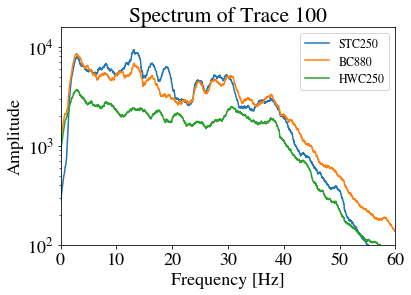

In [ ]:
# Plot spectrum
f1, A1 = fftSpectrum(stc250_tr, 1000, window=100, flim=(0,60), plot=False)
f2, A2 = fftSpectrum(bc880_tr, 1000, window=100, flim=(0,60), plot=False)
f3, A3 = fftSpectrum(hwc250_tr, 1000, window=100, flim=(0,60), plot=False)

plt.semilogy(f1, A1, label='STC250')
plt.semilogy(f2, A2, label='BC880')
plt.semilogy(f3, A3, label='HWC250')

plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.xlim(0,60)
plt.ylim(ymin=1e2)
plt.title('Spectrum of Trace {}'.format(no_chann))
plt.legend(fontsize=12)

plt.show()

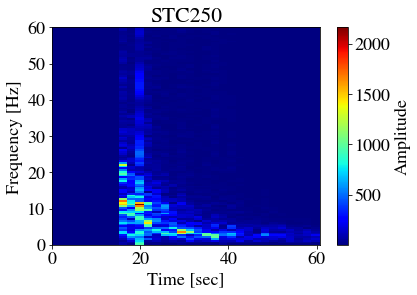

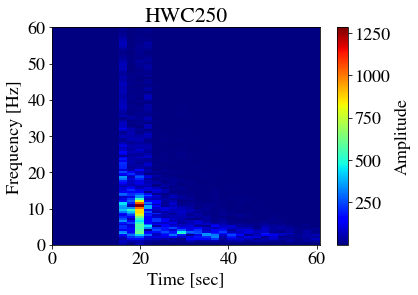

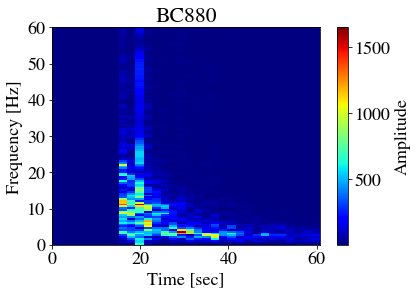

In [ ]:
# Plot spectrogram
stftSpectrogram(stc250_tr, fs=1/0.001, nperseg=2000, noverlap=100)
plt.title('STC250')
plt.ylim(0,60)
plt.show()

stftSpectrogram(hwc250_tr, fs=1/0.001, nperseg=2000, noverlap=100)
plt.title('HWC250')
plt.ylim(0,60)
plt.show()

stftSpectrogram(bc880_tr, fs=1/0.001, nperseg=2000, noverlap=100)
plt.title('BC880')
plt.ylim(0,60)
plt.show()

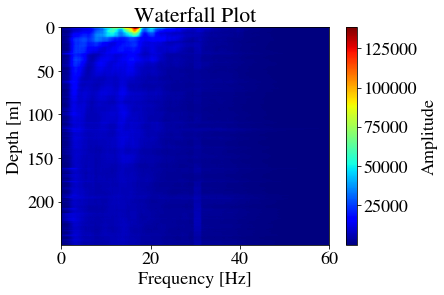

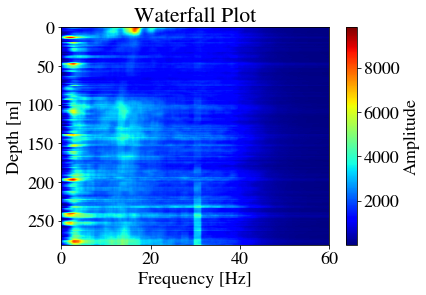

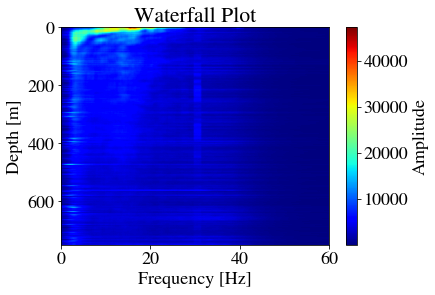

In [ ]:
no_event = 3

# Multi-channel data
stc250 = stc[no_event-1,::]
hwc250 = hwc[no_event-1,::]
bc880 = bc[no_event-1,::]
dz = 1.019

das_list = [stc250, hwc250, bc880]

for das in das_list:
  nt,nz = das.shape # nt: time samples, nz: number of channels

  z = np.arange(0, nz*dz, dz)

  frqAmps = []
  for trace in range(nz):
    f, A = fftSpectrum(das[:,trace], fs=1/0.001, window=100, plot=False)
    frqAmps.append(A)

  frqs = np.array(f)
  frqAmps = np.array(frqAmps) 

  # Waterfall plot of spectral magnitude with depth vs. frequency axis
  plotWaterfall(frqs, z, frqAmps, xlim=(0,60), vmax=None, # 1.2e4
                xlabel='Frequency [Hz]', ylabel='Depth [m]', clabel='Amplitude')
  # plt.xlim(15,30)
  # plt.ylim(250,0)
  # plt.ylim(ymax=100)
  plt.show()

## Spectrum comparison of depth

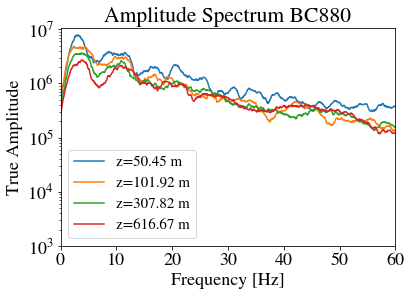

In [ ]:
das = bc # Specify stc, hwc, or bc
no_event = 1 # Specify which event
no_chann = 100

# Multi-channel data
data = das[no_event-1,::]
nt, nz = data.shape # Number of time samples, number of channels

# Single-channel data
y = data[:,no_chann-1]

# Time samples
dt = .001 # Sampling interval
t = np.arange(0, nt*dt, dt)

# Channel depths
dz = 1.0295 # Channel interval
z = np.arange(0, nz*dz, dz)

#----
# Specify channels at different depths
no_trace = [50,100,300,600]

for i in no_trace:
  tr = data[:,i-1]
  f, A = fftSpectrum(tr, fs=1/0.001, window=100, plot=False)
  plt.semilogy(f, A, label='z={:.2f} m'.format(z[i-1]))

plt.title('Amplitude Spectrum BC880')
plt.xlabel('Frequency [Hz]')
plt.ylabel('True Amplitude')
plt.xlim(0,60)
plt.ylim(ymin=1E+3)
plt.legend(fontsize=15, loc='lower left')
plt.show()